# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

from math import * 
from collections import Counter
from tqdm.notebook import tqdm
tqdm.pandas()

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from tensorflow import keras
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.python.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional, GlobalMaxPooling1D

from sklearn.model_selection import train_test_split
from   sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import chi2, RFE, SelectFromModel, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, RocCurveDisplay, classification_report 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression

from sklearn.ensemble import (
    BaggingClassifier,
    StackingClassifier,
    AdaBoostClassifier, 
    ExtraTreesClassifier,
    RandomForestClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier, 
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from pycaret.classification import ClassificationExperiment



# 2. Load Data

In [3]:
data = pd.read_csv('../Dataset/churn.csv',na_values=' ').dropna()
data = data.drop(columns='customerID')
data = data.drop_duplicates()
# data = data.replace(' ', np.nan)
data

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


# 3. Initial Analysis

### 3.1. Metadata

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7010 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7010 non-null   int32  
 1   SeniorCitizen     7010 non-null   int64  
 2   Partner           7010 non-null   int32  
 3   Dependents        7010 non-null   int32  
 4   tenure            7010 non-null   int64  
 5   PhoneService      7010 non-null   int32  
 6   MultipleLines     7010 non-null   int32  
 7   InternetService   7010 non-null   int32  
 8   OnlineSecurity    7010 non-null   int32  
 9   OnlineBackup      7010 non-null   int32  
 10  DeviceProtection  7010 non-null   int32  
 11  TechSupport       7010 non-null   int32  
 12  StreamingTV       7010 non-null   int32  
 13  StreamingMovies   7010 non-null   int32  
 14  Contract          7010 non-null   int32  
 15  PaperlessBilling  7010 non-null   int32  
 16  PaymentMethod     7010 non-null   int32  


In [146]:
data.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,7010,2,Male,3535,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SeniorCitizen,7010.0,NaN,NaN,NaN,0.162767,0.36918,0.0,0.0,0.0,0.0,1.0
Partner,7010,2,No,3617,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dependents,7010,2,No,4911,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tenure,7010.0,NaN,NaN,NaN,32.520399,24.520441,1.0,9.0,29.0,56.0,72.0
PhoneService,7010,2,Yes,6330,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultipleLines,7010,3,No,3363,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InternetService,7010,3,Fiber optic,3090,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineSecurity,7010,3,No,3489,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OnlineBackup,7010,3,No,3079,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [147]:
data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [148]:
no_of_columns = data.shape[0]
percentage_of_missing_data = data.isnull().sum()/no_of_columns
print(percentage_of_missing_data)

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64


In [149]:
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of duplicates data : 0


In [150]:
data.nunique()

gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                72
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1584
TotalCharges        6530
Churn                  2
dtype: int64

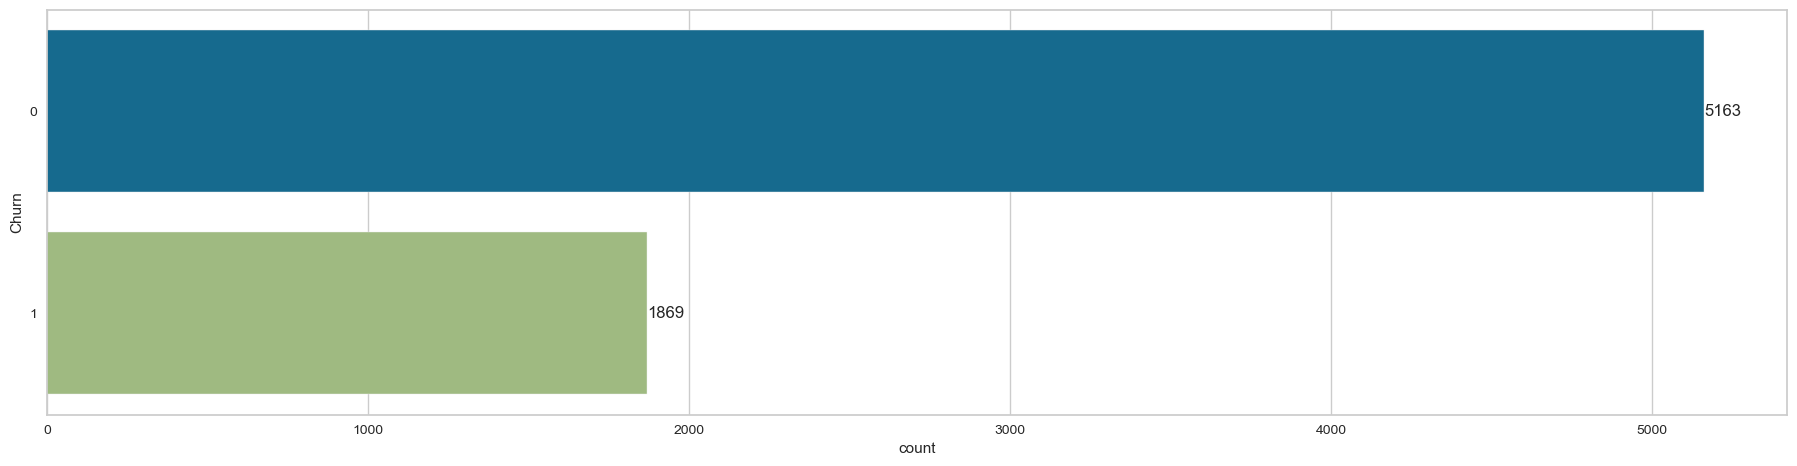

In [105]:
plt.subplots(figsize=(20,5))
ax = sns.countplot(data, y=data['Churn'])
ax.bar_label(ax.containers[0])
plt.show()

### 3.2. Columns Processing

In [130]:
# data['TotalCharges'] = data['TotalCharges'].astype(float)

In [4]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']

print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical Columns : ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


In [5]:
def change_columns_to_numerical(data):
    LE = LabelEncoder()

    for column in categorical_columns:
        data[column] = LE.fit_transform(data[column])
        # data[column] = data[column].astype(int)
        data[column] = pd.to_numeric(data[column], errors='coerce')
        print(f'{column} : {LE.classes_}') 

    for column in numerical_columns:
        data[column] = pd.to_numeric(data[column], errors='coerce')
        data[column].fillna(data[column].mean(), inplace=True)

    return data

data = change_columns_to_numerical(data)

gender : ['Female' 'Male']
Partner : ['No' 'Yes']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No' 'No phone service' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'No internet service' 'Yes']
OnlineBackup : ['No' 'No internet service' 'Yes']
DeviceProtection : ['No' 'No internet service' 'Yes']
TechSupport : ['No' 'No internet service' 'Yes']
StreamingTV : ['No' 'No internet service' 'Yes']
StreamingMovies : ['No' 'No internet service' 'Yes']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['No' 'Yes']
PaymentMethod : ['Bank transfer (automatic)' 'Credit card (automatic)' 'Electronic check'
 'Mailed check']
Churn : ['No' 'Yes']


### 3.3. EDA

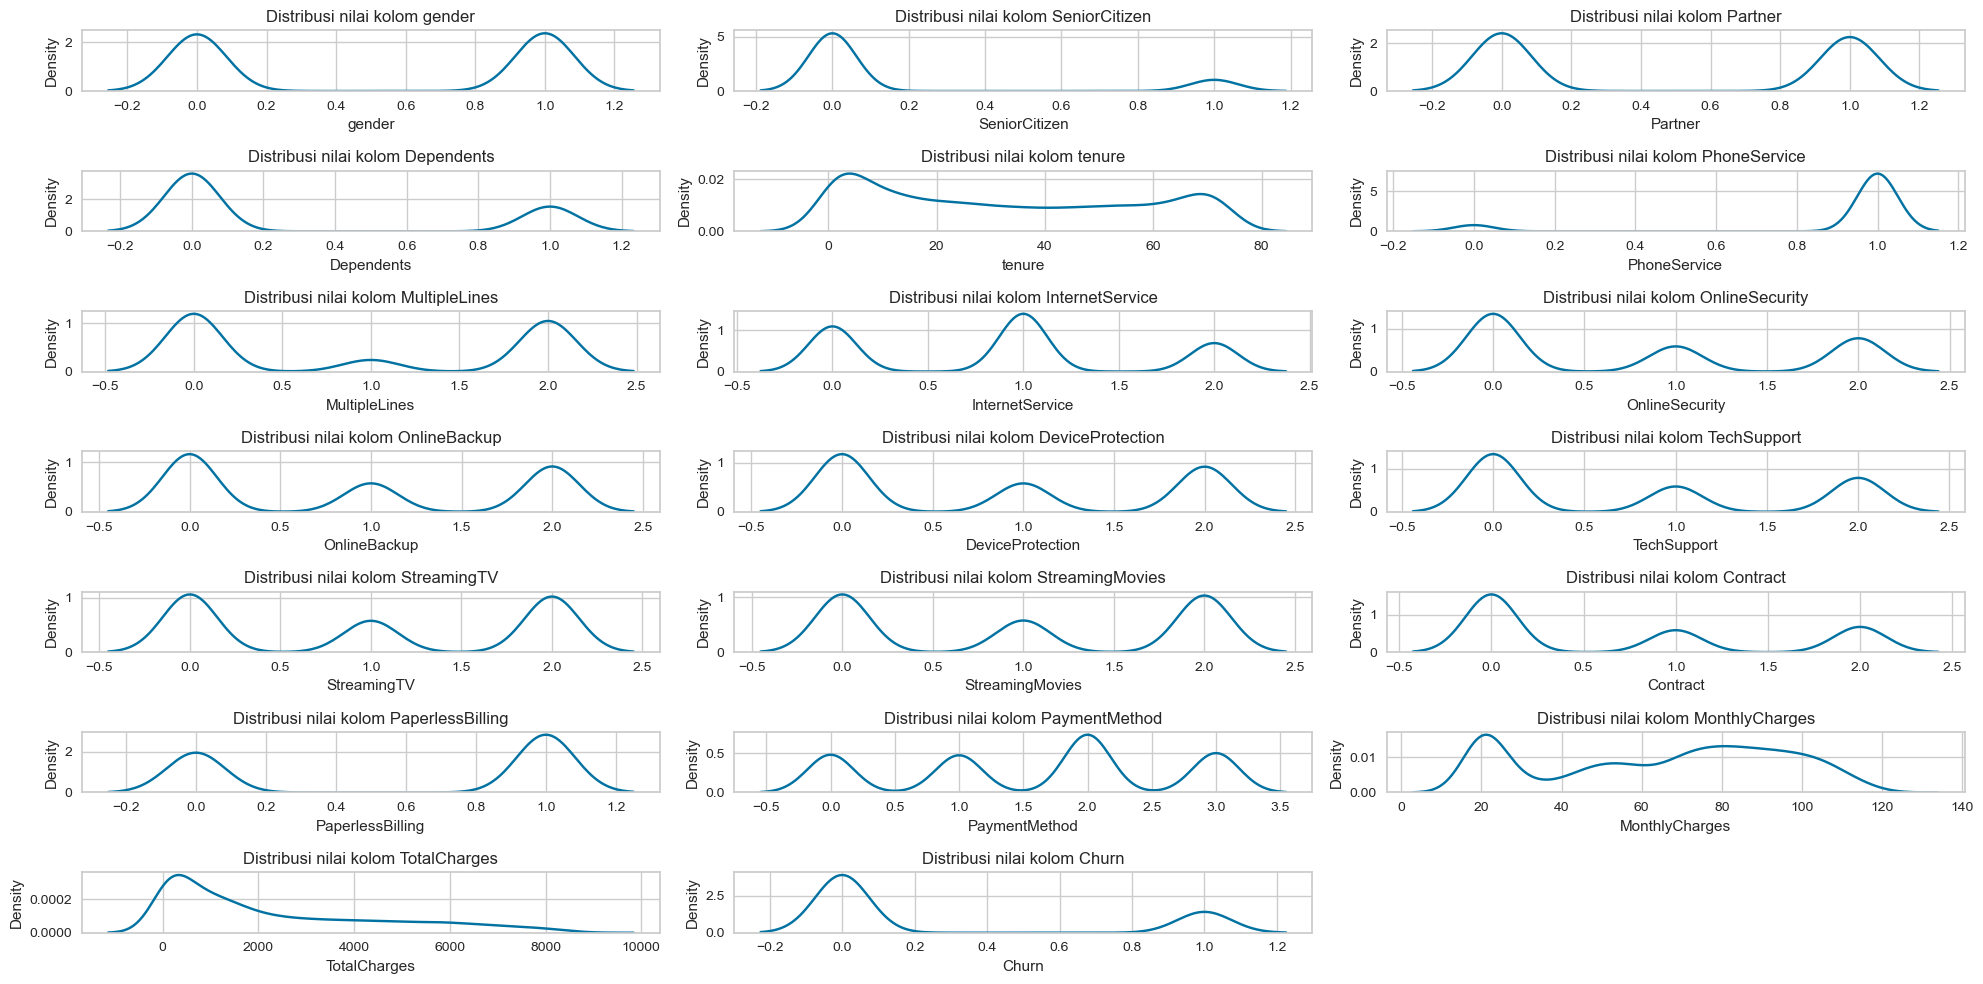

In [63]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col]) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

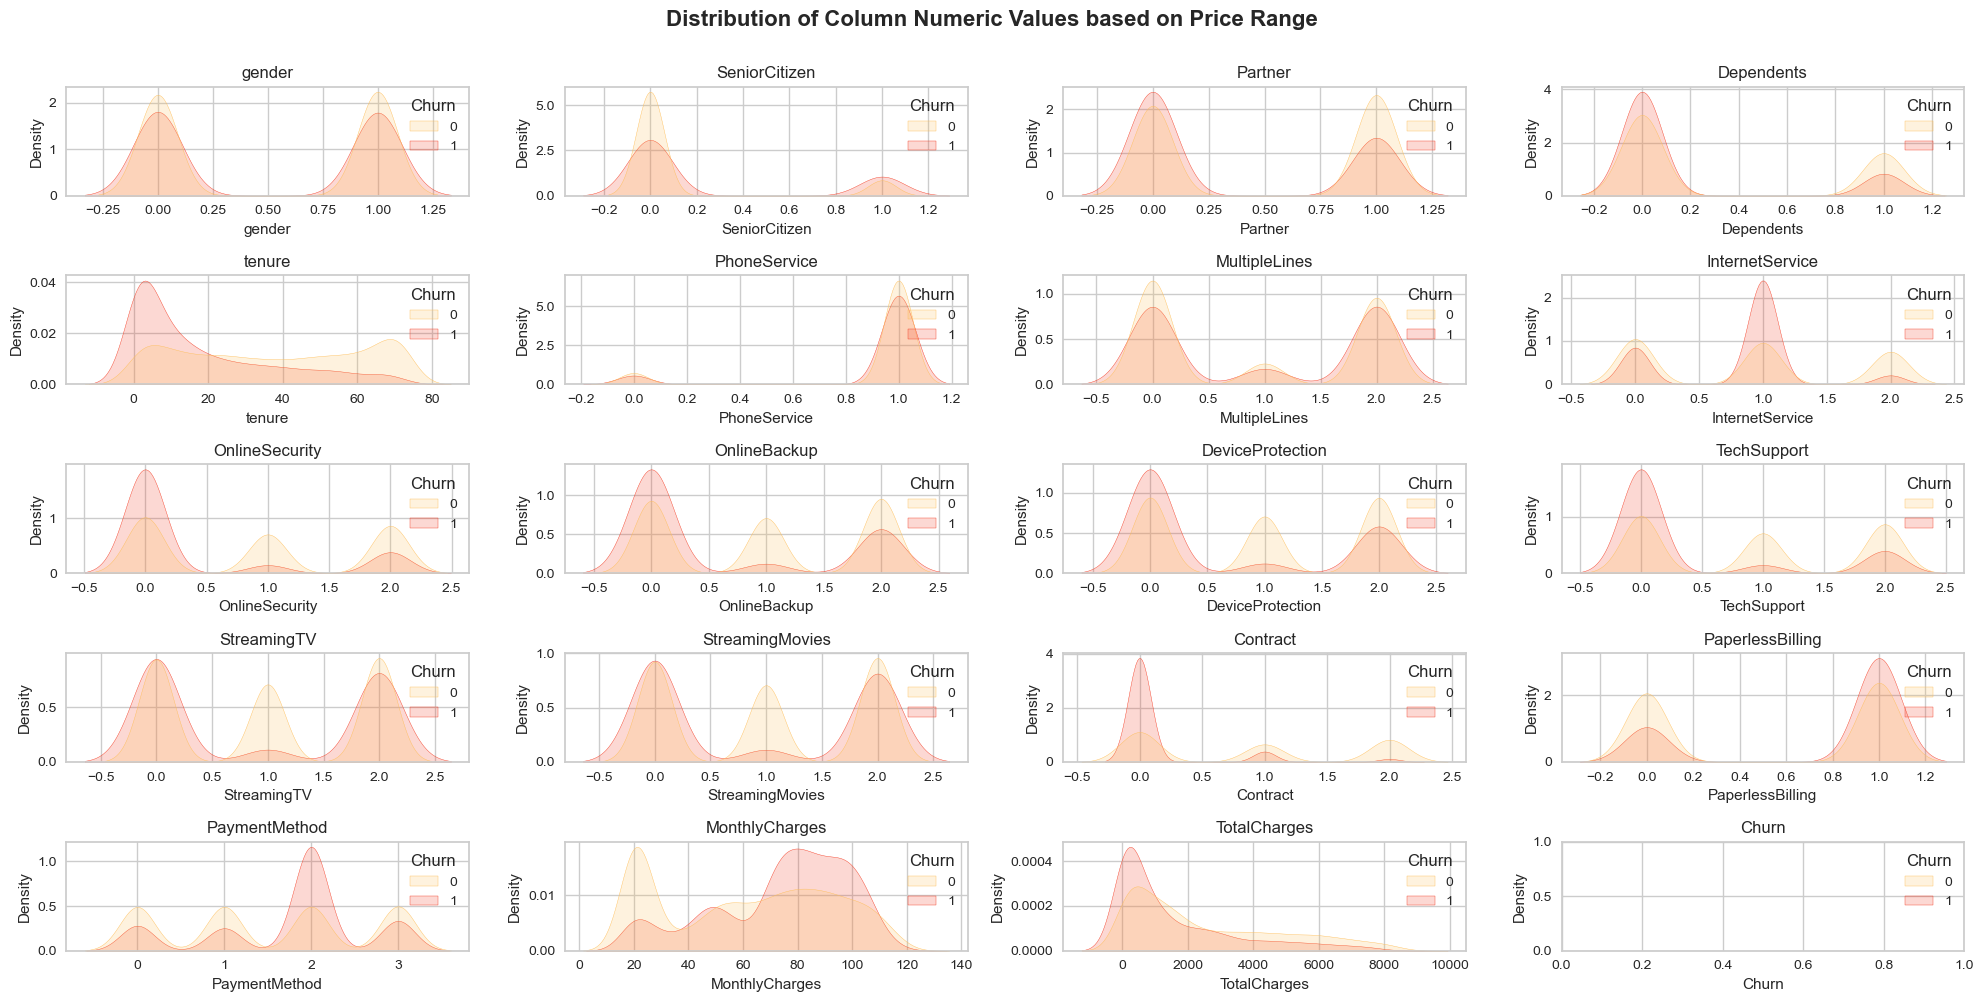

In [68]:
num_cols = 4
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=data, x=column, hue="Churn", 
                fill=True, alpha=.2, palette="YlOrRd", 
                common_norm=False, ax=axes[row, col],
                warn_singular=False)\
        .set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

fig.suptitle('Distribution of Column Numeric Values based on Price Range', y=1.0, fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [69]:
# plt.figure(figsize=(20, 10))

# plt.scatter(data.age[data.target==1],
#             data.thalach[data.target==1],
#             c="salmon")

# plt.scatter(data.age[data.target==0],
#             data.thalach[data.target==0],
#             c="lightblue")

# plt.title("Heart Disease in function of Age and Max Heart Rate")
# plt.xlabel("Age")
# plt.ylabel("Max Heart Rate")
# plt.legend(["Disease", "No Disease"])

In [ ]:
sns.pairplot(data, hue='grades')

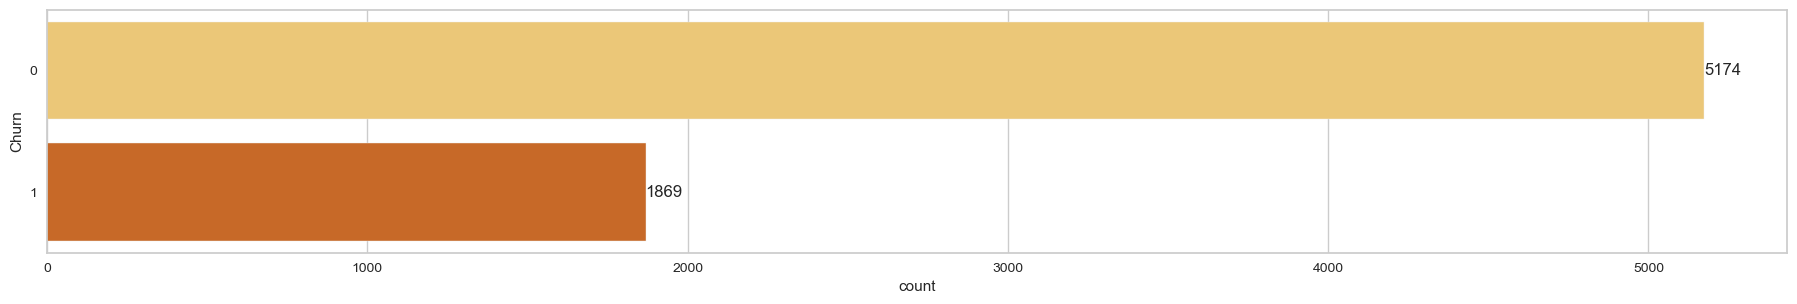

In [72]:
plt.subplots(figsize = (20,3))
ax = sns.countplot(data = data, y = 'Churn', palette='YlOrBr')
ax.bar_label(ax.containers[0])
plt.show()

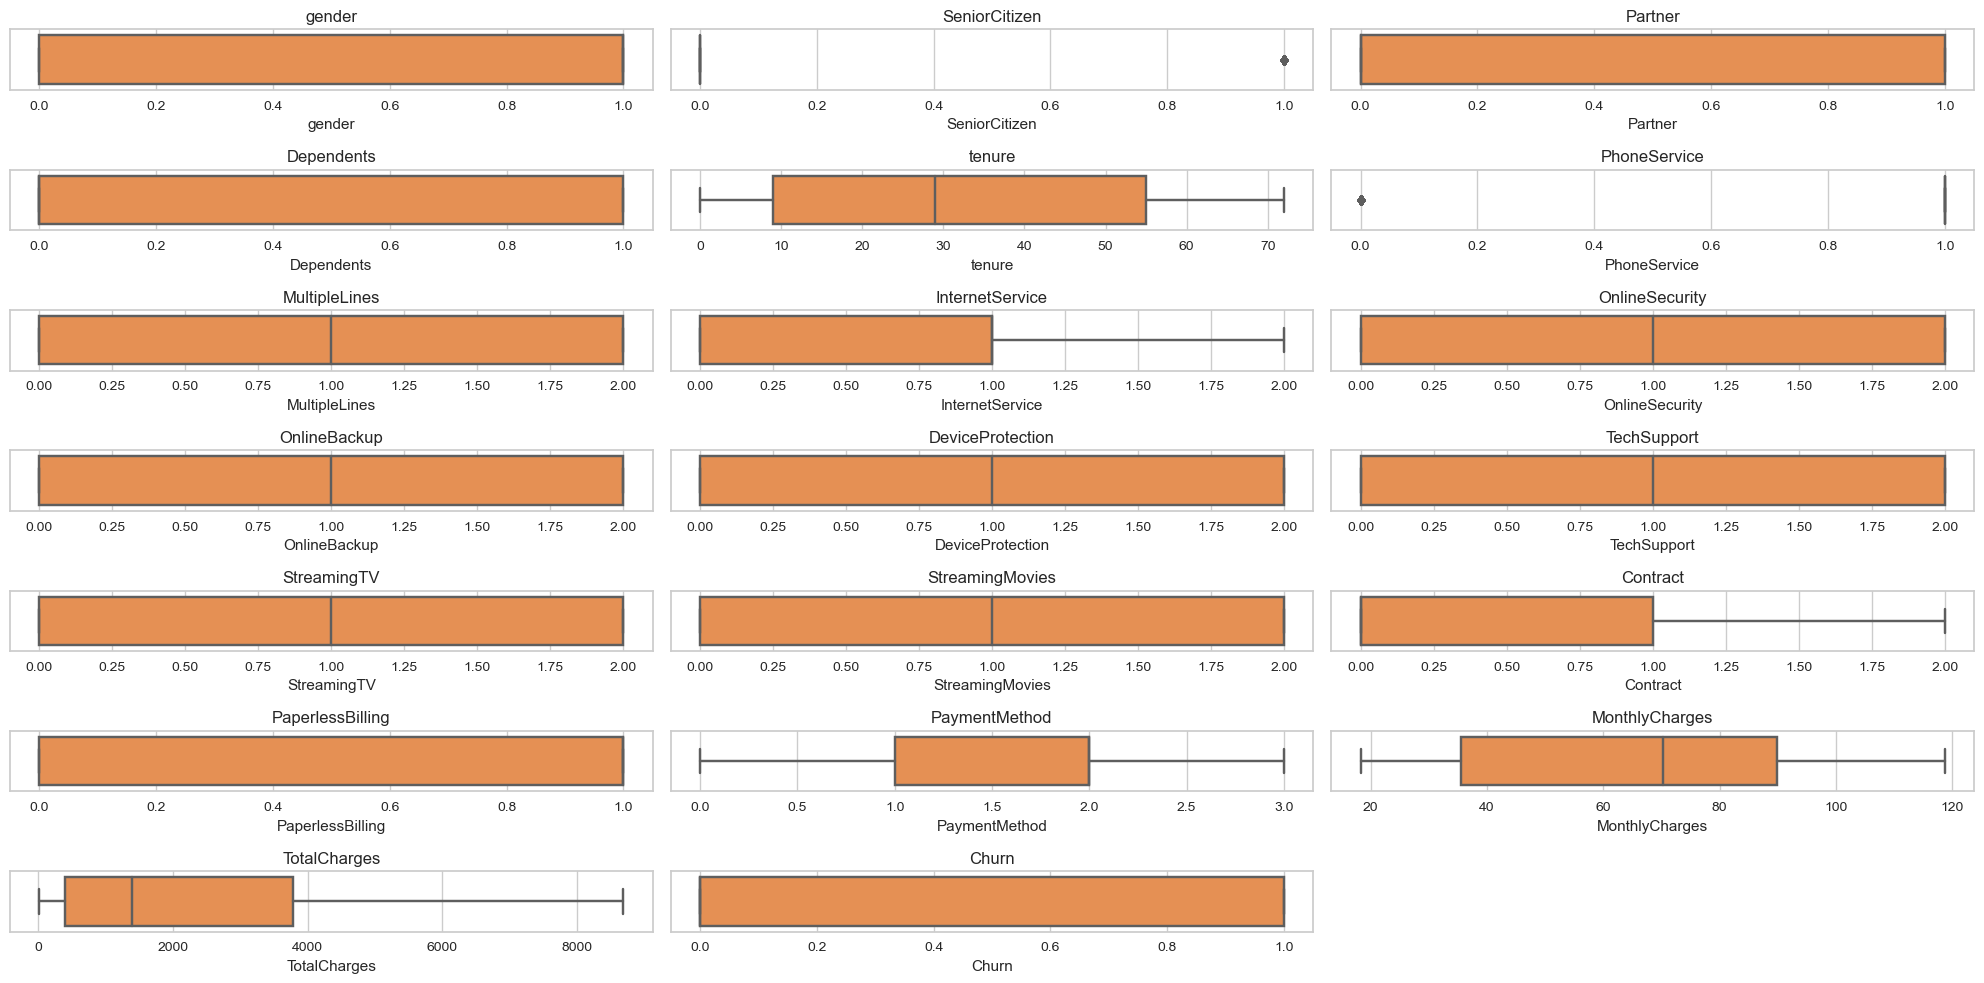

In [73]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

Text(0.5, 1.0, 'Correlation Matrix')

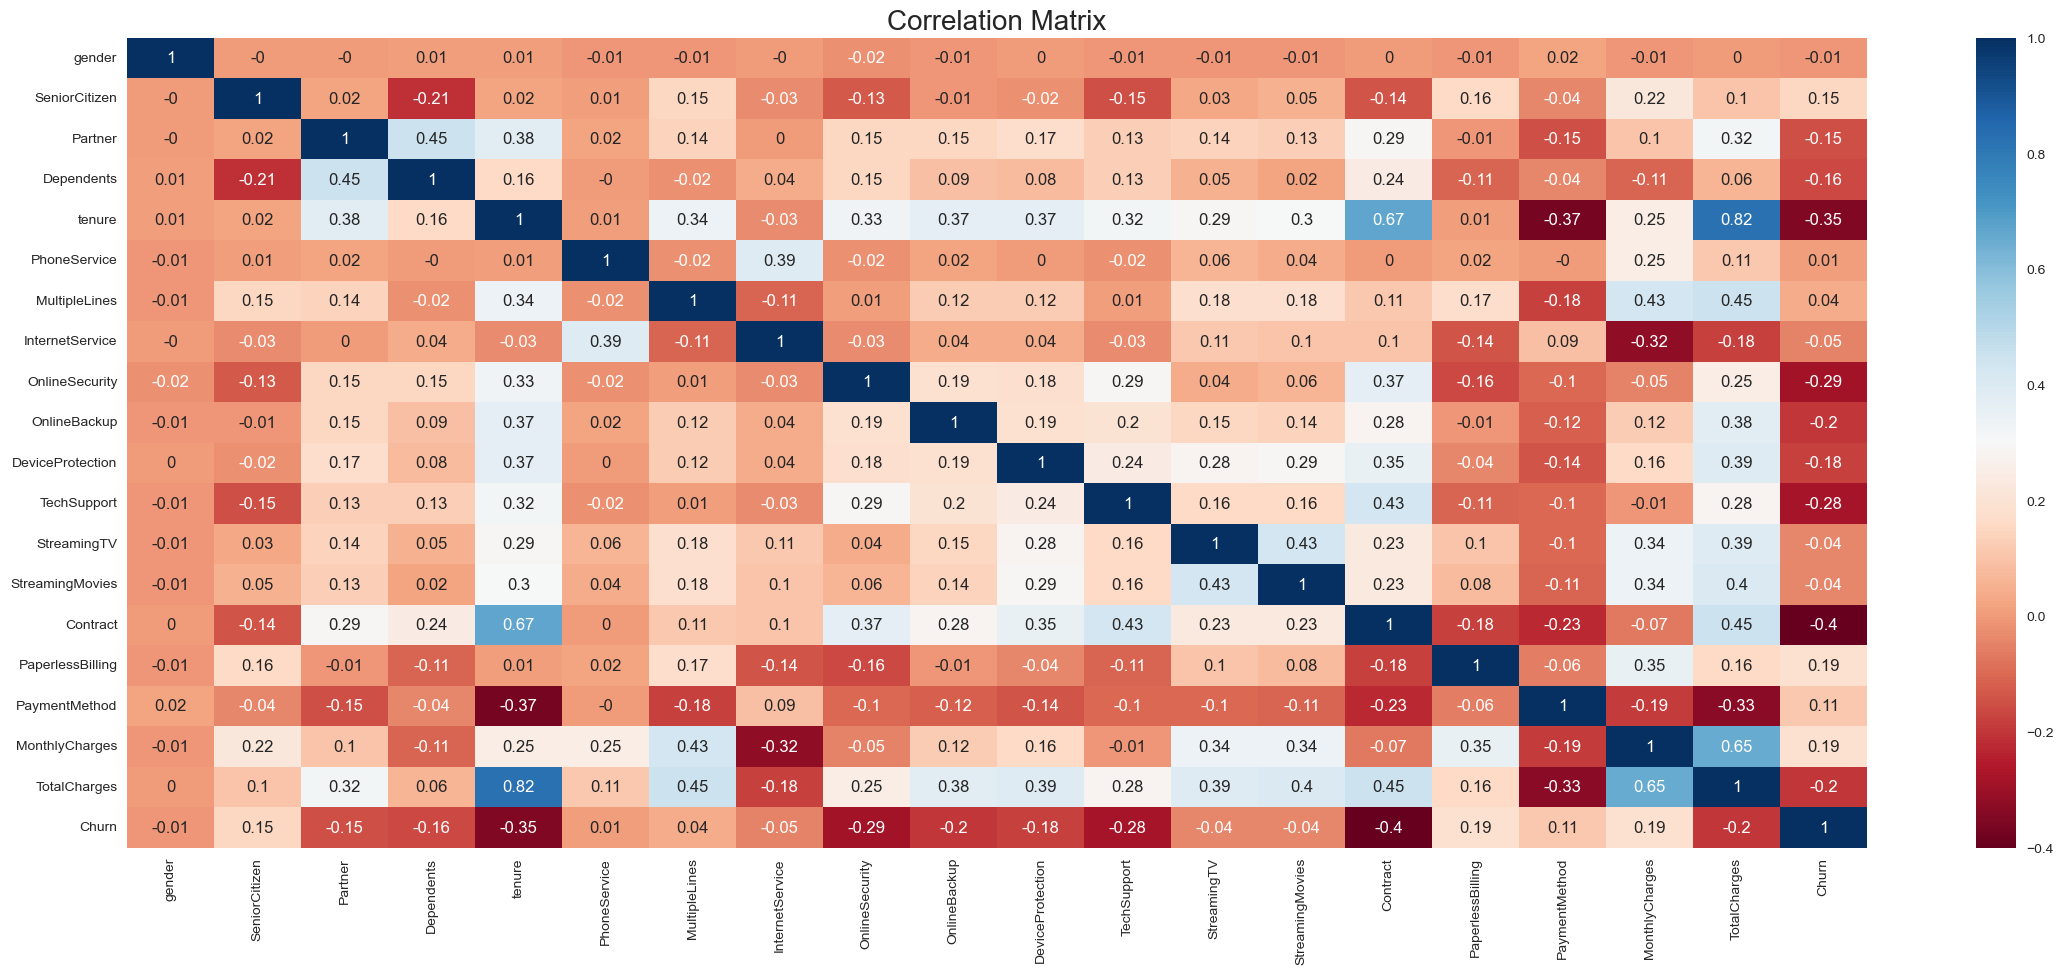

In [66]:
corr_data = data[numerical_columns].corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 4. Data Preprocessing

### 4.1. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


# 5 Neural Network Algoritms

In [6]:
X = data.drop(columns=['Churn']).values
Y = data['Churn']

print(Counter(Y))
# sampling = RandomUnderSampler()
sampling = SMOTE()
X, Y = sampling.fit_resample(X, Y)
print(Counter(Y))

Y = pd.get_dummies(Y).values

# scaler = MinMaxScaler(feature_range=(0,1))
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

label = y_train.shape[1]

Counter({0: 5153, 1: 1857})
Counter({0: 5153, 1: 5153})
(7234, 19) (7234, 2)
(2041, 19) (2041, 2)
(1031, 19) (1031, 2)


In [24]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(4096, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01), input_shape=(X_train.shape[1],)))
    model.add(Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
    model.add(Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.01)))
    model.add(Dense(label, activation='softmax'))
    
    return model

def CNN_Model():
    model = Sequential()

    model.add(Conv1D(128, 3, kernel_regularizer=keras.regularizers.l2(l=0.001), input_shape=(X_train.shape[1], 1)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.8))
    model.add(MaxPooling1D())

    # model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    # model.add(LeakyReLU(0.2))
    model.add(ReLU())
    # model.add(Dropout(0.5))
    model.add(MaxPooling1D())

    # model.add(Conv1D(16, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(BatchNormalization())
    # # model.add(LeakyReLU(0.2))
    # model.add(ReLU())
    # # model.add(Dropout(0.5))
    # model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    # model.add(Dropout(0.5))
    model.add(Dense(label, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add((LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], 1))))
    model.add((LSTM(256)))
    # model.add(Dense(32, activation='swish'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(label, activation='sigmoid'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1)))
    model.add(GRU(256, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True))
    model.add(Dense(label, activation='softmax'))
    return model
    

model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = RMSprop(learning_rate = 0.001)
# opt = SGD(learning_rate = 0.001)
opt = Adam(learning_rate = 0.000_001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 4096)              81920     
                                                                 
 dense_13 (Dense)            (None, 1024)              4195328   
                                                                 
 dense_14 (Dense)            (None, 256)               262400    
                                                                 
 dense_15 (Dense)            (None, 2)                 514       
                                                                 
Total params: 4,540,162
Trainable params: 4,540,162
Non-trainable params: 0
_________________________________________________________________


In [31]:
num_epoch = 50
batch_size = 64

history = model.fit(X_train, y_train, verbose = 2,
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_test, y_test))

Epoch 1/50
114/114 - 1s - loss: 1.7863 - accuracy: 0.7980 - val_loss: 1.8091 - val_accuracy: 0.7844 - 903ms/epoch - 8ms/step
Epoch 2/50
114/114 - 1s - loss: 1.7828 - accuracy: 0.7985 - val_loss: 1.8058 - val_accuracy: 0.7844 - 568ms/epoch - 5ms/step
Epoch 3/50
114/114 - 1s - loss: 1.7793 - accuracy: 0.7991 - val_loss: 1.8024 - val_accuracy: 0.7834 - 558ms/epoch - 5ms/step
Epoch 4/50
114/114 - 1s - loss: 1.7757 - accuracy: 0.7983 - val_loss: 1.7991 - val_accuracy: 0.7844 - 552ms/epoch - 5ms/step
Epoch 5/50
114/114 - 1s - loss: 1.7722 - accuracy: 0.7982 - val_loss: 1.7956 - val_accuracy: 0.7844 - 560ms/epoch - 5ms/step
Epoch 6/50
114/114 - 1s - loss: 1.7687 - accuracy: 0.8000 - val_loss: 1.7925 - val_accuracy: 0.7834 - 551ms/epoch - 5ms/step
Epoch 7/50
114/114 - 1s - loss: 1.7653 - accuracy: 0.8002 - val_loss: 1.7892 - val_accuracy: 0.7844 - 574ms/epoch - 5ms/step
Epoch 8/50
114/114 - 1s - loss: 1.7618 - accuracy: 0.8002 - val_loss: 1.7855 - val_accuracy: 0.7854 - 557ms/epoch - 5ms/step


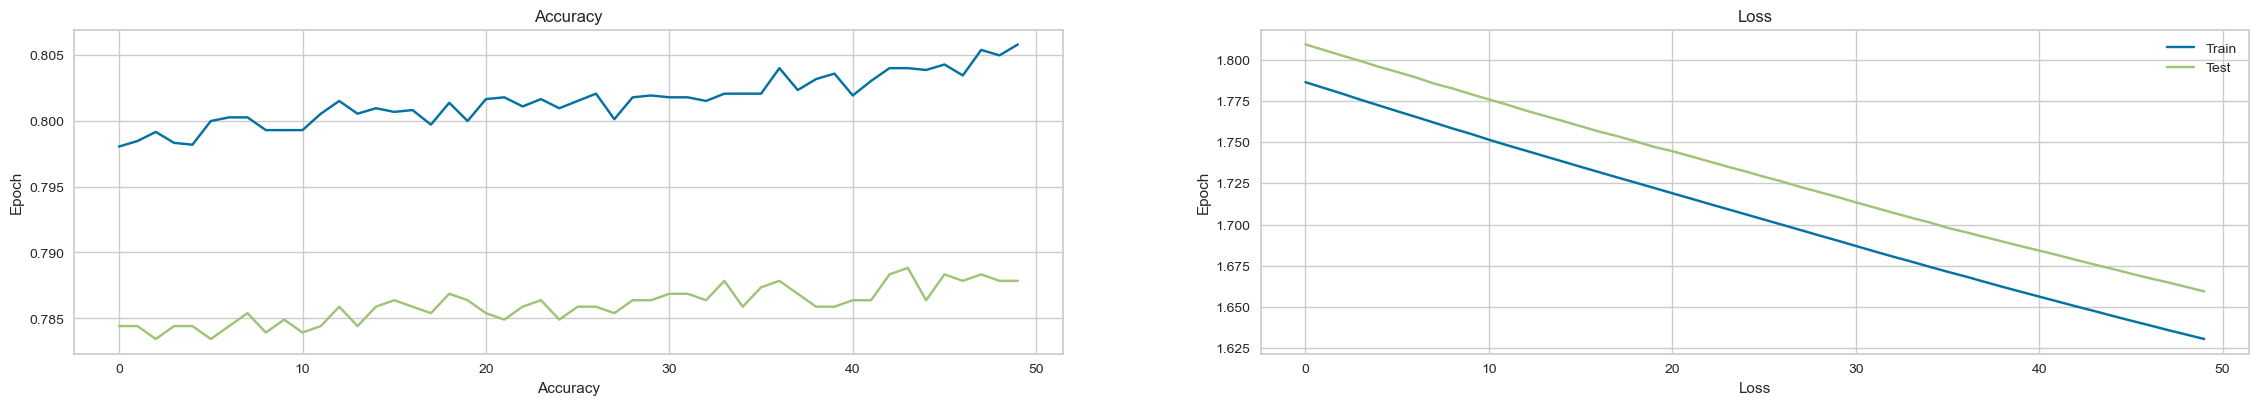

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 4))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [33]:
from sklearn.metrics import classification_report
y_pred = np.rint(model.predict(X_val, verbose=0))

print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       520
           1       0.79      0.81      0.80       511

   micro avg       0.80      0.80      0.80      1031
   macro avg       0.80      0.80      0.80      1031
weighted avg       0.80      0.80      0.80      1031
 samples avg       0.80      0.80      0.80      1031



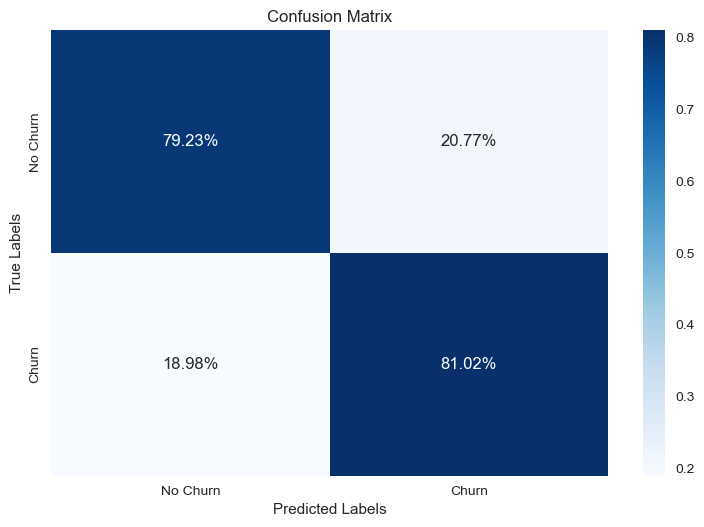

In [34]:
labels = ['No Churn', 'Churn']

y_pred = np.rint(model.predict(X_val, verbose=0).argmax(axis=1))
con_mat = confusion_matrix(y_val.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# 6. Supervised Learning

In [35]:
X = data.drop(columns=['Churn']).values
Y = data['Churn']

print(Counter(Y))
# undersample = RandomUnderSampler()
undersample = SMOTE()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = Y.values

# scaler = MinMaxScaler(feature_range=(0,1))
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.9, random_state = 42)

print(X_train.shape)
print(X_test.shape)

Counter({0: 5153, 1: 1857})
Counter({0: 5153, 1: 5153})
(9275, 19)
(1031, 19)


### 6.2 Stacking Classifier

In [36]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradient = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)
pac = PassiveAggressiveClassifier(random_state=42)
linear = LogisticRegression(random_state=42)

model = StackingClassifier([
    ('bagging', bagging),
    ('adaboost', adaboost),
    ('extraTress', extraTrees),
    ('randomforest', randomForest),
    ('decisionTree', decisionTree),
    ('histGradient', histGradient),
    ('XGB', XGB),
    ('pac', pac),
    ('linear', linear),
    # ('gradient', gradient),
    # ('knn', knn),
], n_jobs=-1)

In [37]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('adaboost',
                                AdaBoostClassifier(n_estimators=100,
                                                   random_state=42)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=100, n_jobs=-1,
                                                     random_state=42)),
                               ('randomforest',
                                RandomForestClassifier(max_depth=100, n_jobs=-1,
                                                       random_state=42)),
                               ('decisionTree',
                                DecisionTreeClassifier(max_depth=100,
                                                       r...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...)),
                               ('pac',
                                PassiveAggressiveClassifier(random_state=42)),
                               ('linear', LogisticRegression(random_state=42))],
                   n_jobs=-1)

In [38]:
print("Train Score : ",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score  : ",round((model.score(X_test, y_test)*100), 2),'%')

Train Score :  98.77 %
Test Score  :  86.52 %


In [39]:
y_pred = model.predict(X_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       555
           1       0.83      0.89      0.86       476

    accuracy                           0.87      1031
   macro avg       0.86      0.87      0.86      1031
weighted avg       0.87      0.87      0.87      1031



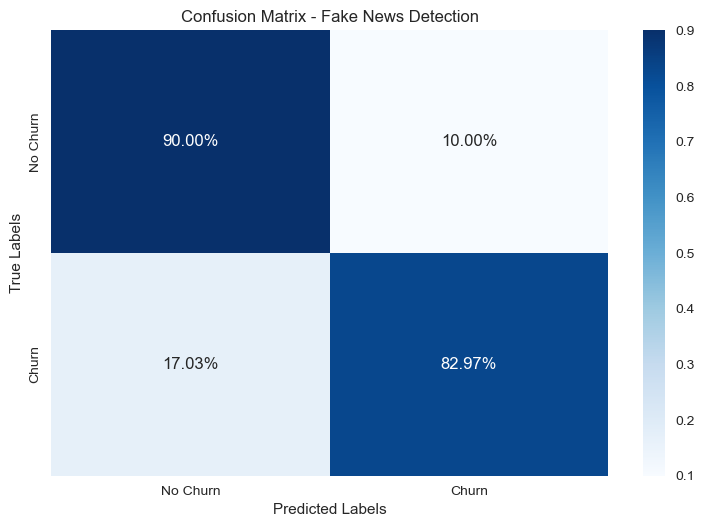

In [40]:
labels = ['No Churn', 'Churn']

y_pred = model.predict(X_test)
con_mat = confusion_matrix(y_test,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

### 6.2. Pycaret

In [45]:
s = ClassificationExperiment()
s.setup(data, target = 'target', session_id = 123)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Binary
3,Original data shape,"(302, 14)"
4,Transformed data shape,"(302, 14)"
5,Transformed train set shape,"(211, 14)"
6,Transformed test set shape,"(91, 14)"
7,Numeric features,13
8,Preprocess,True
9,Imputation type,simple


In [46]:
best = s.compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,21:18:11
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [ ]:
s.evaluate_model(best)


In [48]:
print(best)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [49]:
s.predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8462,0.9082,0.9184,0.8182,0.8654,0.6873,0.6935


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,prediction_label,prediction_score
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0,0,0.9656
276,58,1,0,146,218,0,1,105,0,2.0,1,1,3,0,0,0.9710
84,42,0,0,102,265,0,0,122,0,0.6,1,0,2,1,1,0.6207
141,43,1,0,115,303,0,1,181,0,1.2,1,0,2,1,1,0.6176
226,62,1,1,120,281,0,0,103,0,1.4,1,1,3,0,0,0.9002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2,1,1,0.9173
11,48,0,2,130,275,0,1,139,0,0.2,2,0,2,1,1,0.9615
81,45,1,1,128,308,0,0,170,0,0.0,2,0,2,1,1,0.8216
162,41,1,1,120,157,0,1,182,0,0.0,2,0,2,1,1,0.9372


In [12]:
lgbm = s.create_model('xgboost')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:02:50
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7718,0.8167,0.7180,0.7497,0.7335,0.5342,0.5346
1,0.7747,0.8213,0.7183,0.7547,0.7360,0.5396,0.5401
2,0.7757,0.8226,0.7208,0.7552,0.7376,0.5419,0.5424
3,0.7683,0.8147,0.7119,0.7465,0.7288,0.5267,0.5272
4,0.7714,0.8189,0.7178,0.7491,0.7331,0.5334,0.5337
5,0.7700,0.8144,0.7148,0.7482,0.7311,0.5304,0.5308
6,0.7762,0.8220,0.7227,0.7552,0.7386,0.5432,0.5436
7,0.7739,0.8207,0.7208,0.7520,0.7361,0.5385,0.5389
8,0.7744,0.8216,0.7189,0.7538,0.7360,0.5392,0.5397


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
X = data.drop(columns=['satisfaction']).values
Y = data['satisfaction']

In [37]:
scores = cross_val_score(lgbm, X_train, y_train, cv=20)

NameError: name 'X_train' is not defined

<Axes: >

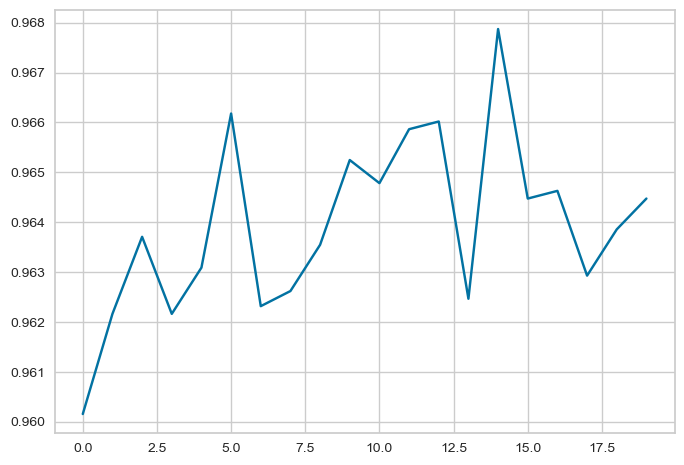

In [22]:
sns.lineplot(scores)

In [16]:
preds = s.predict_model(lgbm)
preds

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7745,0.8197,0.7199,0.7531,0.7362,0.5394,0.5399


In [36]:
pred = (abs(preds['satisfaction'] - preds['prediction_label'])).sum()

print(f'{pred} / {preds.shape[0]} : {round(pred/preds.shape[0]*100, 2)} % (False Predictions)')

33248 / 147438 : 22.55 % (False Predictions)
